Antes de rodar o notebook:
- Crie um novo ambiente virtual (e.g. anaconda)
- Instale as libs: netcdf4, xarray, geopandas, matplotlib (demais são instaladas como dependência)
- Para plotar polígonos no notebook, a lib descartes precisa ser instalada
- No Anaconda Prompt rode conda activate "nome_do_seu_venv" (sem aspas)
- Abra o Jupyter Notebook
- Algum outro problema a respeito do venv no Jupyter notebook, veja: https://stackoverflow.com/questions/37085665/in-which-conda-environment-is-jupyter-executing e https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084
- Os arquivos de precipitação e evapotranspiração podem ser baixados em https://utexas.app.box.com/v/Xavier-etal-IJOC-DATA?sortColumn=name&sortDirection=ASC (apenas um cadastro simples precisa ser feito)

In [1]:
import os
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import rasterio
import matplotlib as plt

In [2]:
datanc = xr.open_dataset('C:/Users/User/Documents/netcdf' + '/' + 'prec_daily_UT_Brazil_v2.2_19800101_19891231.nc')

In [3]:
datanc

<xarray.Dataset>
Dimensions:    (latitude: 162, longitude: 168, time: 3653)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T12:00:00 ... 1989-12-31T12:00:00
  * latitude   (latitude) float32 -34.12 -33.88 -33.62 ... 5.625 5.875 6.125
  * longitude  (longitude) float32 -74.12 -73.88 -73.62 ... -32.88 -32.62 -32.38
Data variables:
    prec       (time, latitude, longitude) float32 ...
Attributes:
    institution:          The University of Texas Austin/Universidade Federal...
    institution_id:       UT at Austin/UFES
    history:              Created Sat Feb 24 08:04:41 2018
    temporal_resolution:  24-hourly
    contact:              alexandre.candido.xavier.ufes@gmail.com,careyking@e...
    update_information:   https://sites.google.com/site/alexandrecandidoxavie...
    main_paper:           Xavier, A. C., King, Carey W. and S., Bridget R. Da...

In [4]:
def pixels_shape(datanc, shape_dir=False, buffer=0):
    """
    This function selects the pixels coordinates within a shapefile geometry. Hence, you have to provide the NetCDF data
    opened by the xarray library and the directory of the shapefile.
    """   
    number = 1
    list_name = []
    for coord_name in list(datanc.coords._names):
        #Generate geodataframe from Xavier pixels
        datanc=datanc.dropna(dim='latitude',how='all')
        datanc=datanc.dropna(dim='longitude',how='all')
        latitudes=datanc.coords['latitude'].values
        longitudes=datanc.coords['longitude'].values
        if longitudes.max()>180:
            datanc['longitude'] = ((datanc.longitudes + 180) % 360 - 180).sortby(datanc.longitudes)    
        x,y=[],[]
        for lati in latitudes:
            longitudes=datanc.sel(latitude=lati)              
            longitudes=longitudes.dropna(dim='longitude',how='all')
            longitudes=longitudes.coords['longitude'].values
            for long in longitudes:
                x.append(long)
                y.append(lati)
        pontos=[Point(x) for x in zip(x,y)]
        crs={'proj':'latlong','ellps':'WGS84','datum':'WGS84','no_def':True} #SC WGS 
        pixels=gpd.GeoDataFrame(crs=crs,geometry=pontos)
    pixels['Latitude'] = pixels.geometry.y
    pixels['Longitude']=pixels.geometry.x
    for lat in pixels.Latitude:
            list_name.append('Pixel '+str(number))
            number += 1
    pixels['Name']= list_name
    #Selecting only pixels within the geometry area
    if shape_dir != False:
        area = gpd.read_file(shape_dir)
        pixels=pixels[pixels.geometry.within(area.geometry[0].buffer(buffer))]
    return pixels

In [5]:
pixels = pixels_shape(datanc)

In [6]:
pixels

,geometry,Latitude,Longitude,Name
0,POINT (-53.37500 -33.62500),-33.625,-53.375,Pixel 1
1,POINT (-53.37500 -33.37500),-33.375,-53.375,Pixel 2
2,POINT (-53.12500 -33.37500),-33.375,-53.125,Pixel 3
3,POINT (-53.37500 -33.12500),-33.125,-53.375,Pixel 4
4,POINT (-53.12500 -33.12500),-33.125,-53.125,Pixel 5
...,...,...,...,...
11294,POINT (-60.37500 4.87500),4.875,-60.375,Pixel 11295
11295,POINT (-60.12500 4.87500),4.875,-60.125,Pixel 11296
11296,POINT (-60.62500 5.12500),5.125,-60.625,Pixel 11297
11297,POINT (-60.37500 5.12500),5.125,-60.375,Pixel 11298


In [7]:
al = gpd.read_file(r'AL.shp')

In [8]:
al

,ID,CD_GEOCODU,NM_ESTADO,NM_REGIAO,geometry
0,1,27,ALAGOAS,NORDESTE,"POLYGON ((-35.46753 -8.81744, -35.46659 -8.817..."


In [9]:
al.to_crs(epsg=4326, inplace=True)
pixels.to_crs(epsg=4326, inplace=True)

<AxesSubplot:>

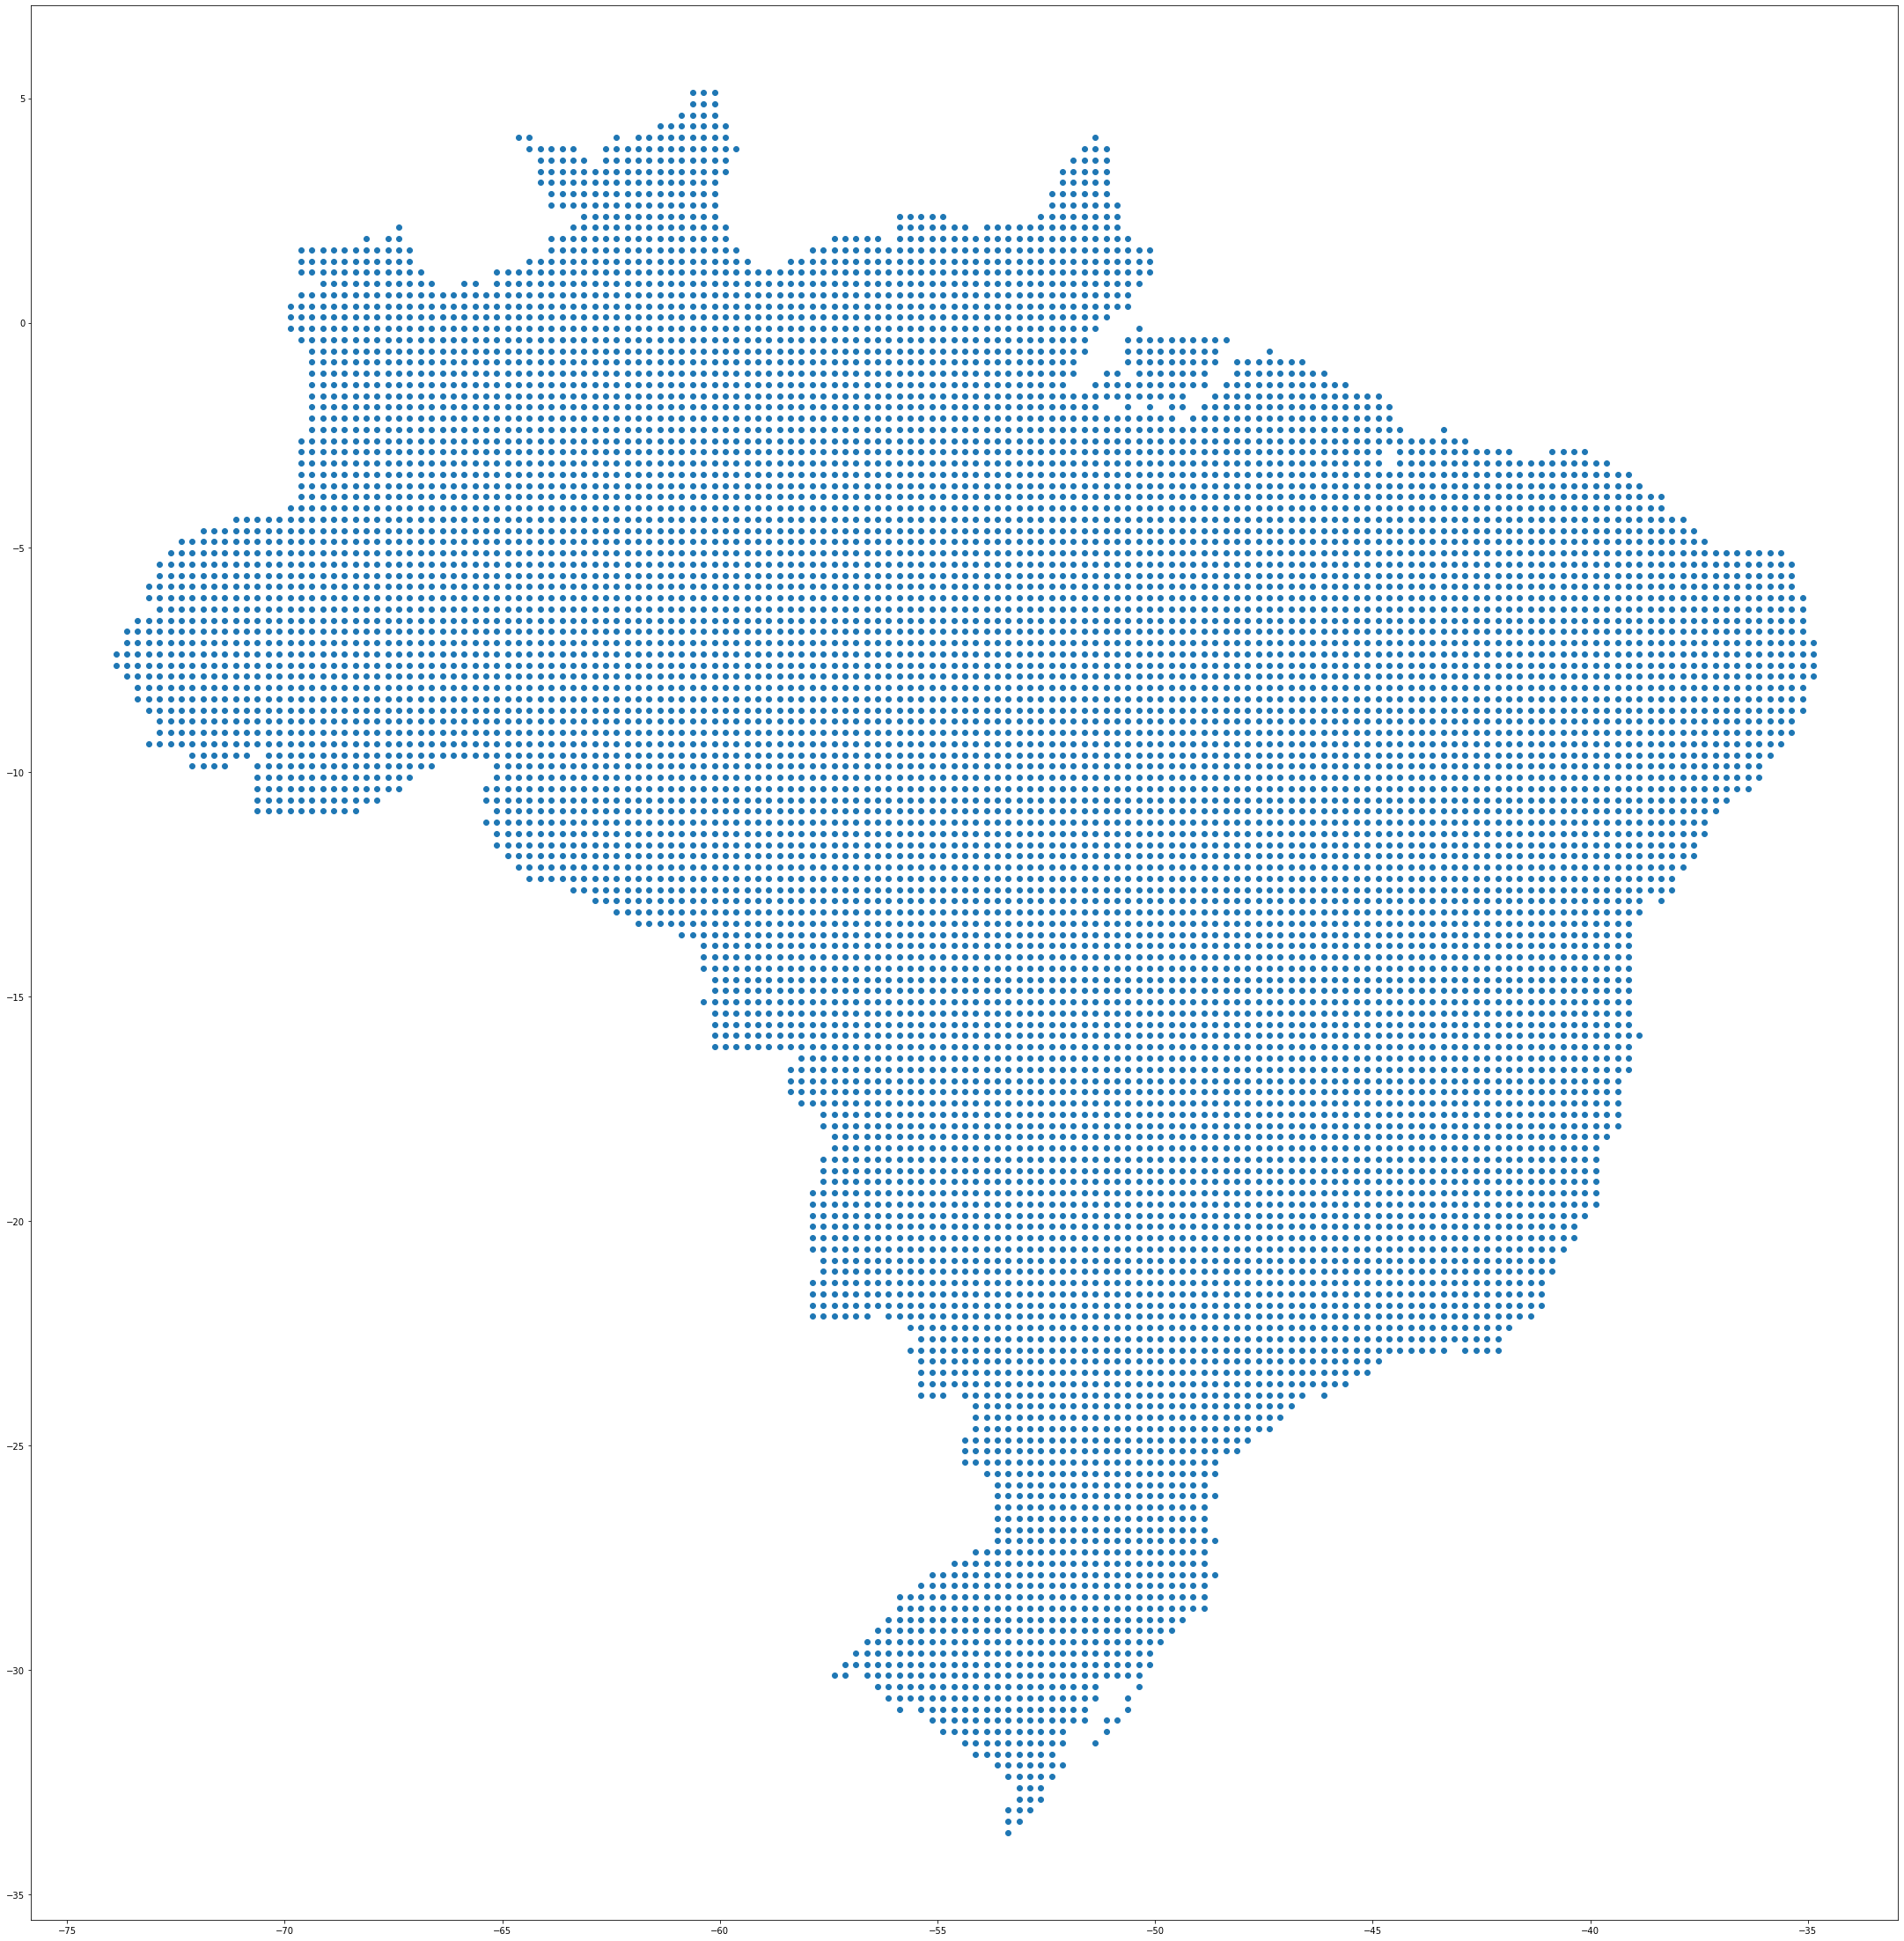

In [10]:
pixels.plot(figsize=(60, 40))

In [11]:
# def pixels_series(data_dir, pixels, var):
#     """
#     This function extracts all data from different NetCDF files in a folder (data_dir) for each pixel provided by the
#     pixels_shape function and return the concated daily time series.
#     :data_dir: str, the dirctory folder where there are the NetCDF files.
#     :pixels: GeoDataFrame, with the values of Latitude and Longitude for each pixel
#     :var: str, the interest variable (e.g. var='prec', var='ETo').
#     """
#     list_files = []
#     for file in os.listdir(data_dir):
#         if file[0:len(var)] == var:
#             list_files.append(file)
#     list_pixels_series = {}
#     for index in pixels.index:
#         pixel_series = pd.DataFrame()
#         for file in list_files:
#             datanc = xr.open_dataset(data_dir + '/' + file)
#             pixel_series = pd.concat([pixel_series, datanc.sel(latitude=pixels.iloc[index].geometry.y,
#                                                                longitude=pixels.iloc[index].geometry.x).to_dataframe()])
#         list_pixels_series[pixels.iloc[index].Name] = pixel_series[var]
#     pixels_series = pd.DataFrame(list_pixels_series)
#     return pixels_series

In [31]:
# data_dir = 'C:/Users/User/Documents/netcdf'
# var = 'prec'
# pixel_series = pixels_series(data_dir, pixels_clipped, var)

In [32]:
# pixel_series

,Pixel 5739,Pixel 5740,Pixel 5889,Pixel 5890,Pixel 5899,Pixel 5903,Pixel 5904,Pixel 5905,Pixel 5906,Pixel 6039,...,Pixel 6817,Pixel 6824,Pixel 6825,Pixel 6833,Pixel 6834,Pixel 6835,Pixel 6970,Pixel 6972,Pixel 6982,Pixel 6983
time,,,,,,,,,,,,,,,,,,,,,
1980-01-01 12:00:00,1.070312,5.906250,0.520508,4.167969,0.000000,0.000000,0.000000,0.000000,0.000000,0.354004,...,0.167236,0.000000,0.000000,0.170288,0.157593,0.035126,0.334717,0.265869,0.000000,0.000000
1980-01-02 12:00:00,3.013672,0.250977,4.355469,0.272705,0.000000,0.177246,0.023438,0.000000,0.000000,0.910156,...,0.351318,0.891602,1.099609,0.000000,0.001751,0.007637,6.707031,3.218750,0.405762,1.471680
1980-01-03 12:00:00,15.117188,17.390625,4.078125,9.062500,0.249634,7.867188,1.699219,1.183594,0.155640,0.000000,...,1.895508,0.518066,1.153320,0.211914,0.198486,0.262939,3.914062,0.352051,1.316406,0.737793
1980-01-04 12:00:00,2.484375,5.390625,9.078125,10.476562,0.352783,18.484375,4.003906,4.890625,1.522461,27.406250,...,2.097656,1.231445,3.718750,0.446777,1.342773,1.950195,9.585938,24.218750,4.578125,8.984375
1980-01-05 12:00:00,21.984375,42.031250,25.437500,38.562500,11.437500,9.750000,13.820312,2.361328,1.361328,10.445312,...,31.343750,14.085938,10.218750,0.302002,1.203125,1.138672,25.125000,23.875000,3.882812,6.472656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.813477,1.358398,1.661133,0.000000,0.000000,0.000000,0.000000
2015-12-28 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.021225,0.219849,0.408936,0.472656,0.000000,...,0.000000,0.000000,0.000000,8.054688,4.640625,4.785156,0.000000,0.000000,0.000000,0.115906
2015-12-29 12:00:00,0.578125,0.578613,0.839355,1.501953,4.292969,1.430664,0.156006,0.217896,0.652344,0.793457,...,0.000000,24.203125,37.812500,41.000000,45.125000,41.187500,0.000000,0.000000,30.531250,28.953125


In [20]:
def monthly_pixels_values(data_dir, pixels, var):
    """
    This function extracts all data from different NetCDF files in a folder (data_dir) for each pixel provided by the
    pixels_shape function and return the long-term monthly mean.
    :data_dir: str, the dirctory folder where there are the NetCDF files.
    :pixels: GeoDataFrame, with the values of Latitude and Longitude for each pixel
    :var: str, the interest variable (e.g. var='prec', var='ETo').
    """
    # Creating the list of files to construct a continuous series
    list_files = []
    for file in os.listdir(data_dir):
        if file[0:len(var)] == var:
            list_files.append(file)

    # Creating the pixel series
    jan, feb, mar, apr, may, jun, jul, aug, sep, out, nov, dec = [], [], [], [], [], [], [], [], [], [], [], []
    for pixel in pixels.geometry:
        pixel_series = pd.DataFrame()
        for file in list_files:
            datanc = xr.open_dataset(data_dir + '/' + file, engine ="netcdf4")
            pixel_series = pd.concat([pixel_series, datanc.sel(latitude=pixel.y, longitude=pixel.x).to_dataframe()])

        pixel_series = pixel_series.groupby(pd.Grouper(freq='M')).sum()
        pixel_series = pixel_series.groupby(by=pixel_series.index.month).mean()
        jan.append(pixel_series[var][1])
        feb.append(pixel_series[var][2])
        mar.append(pixel_series[var][3])
        apr.append(pixel_series[var][4])
        may.append(pixel_series[var][5])
        jun.append(pixel_series[var][6])
        jul.append(pixel_series[var][7])
        aug.append(pixel_series[var][8])
        sep.append(pixel_series[var][9])
        out.append(pixel_series[var][10])
        nov.append(pixel_series[var][11])
        dec.append(pixel_series[var][12])
    # Adding values to the pixels shapefile
    pixels['jan'] = jan
    pixels['feb'] = feb
    pixels['mar'] = mar
    pixels['apr'] = apr
    pixels['may'] = may
    pixels['jun'] = jun
    pixels['jul'] = jul
    pixels['aug'] = aug
    pixels['sep'] = sep
    pixels['out'] = out
    pixels['nov'] = nov
    pixels['dec'] = dec
    return pixels

In [22]:
data_dir = 'C:/Users/User/Documents/netcdf'
var = 'prec'
pixel_series = monthly_pixels_values(data_dir, pixels_clipped, var)

In [23]:
pixel_series

,geometry,Latitude,Longitude,Name,jan,feb,mar,apr,may,jun,jul,aug,sep,out,nov,dec
5192,POINT (-36.37500 -10.37500),-10.375,-36.375,Pixel 5193,42.213276,50.913300,77.372665,147.177979,190.856628,179.856949,167.294754,106.033325,60.799229,48.461796,28.858772,23.243692
5321,POINT (-36.87500 -10.12500),-10.125,-36.875,Pixel 5322,38.116154,38.651527,60.718826,101.137840,138.969116,137.742340,127.665009,78.324097,48.770706,36.862194,23.436893,20.585358
5322,POINT (-36.62500 -10.12500),-10.125,-36.625,Pixel 5323,39.190399,44.716637,69.323036,124.758095,166.523193,163.249039,152.519424,94.515030,56.238400,42.756023,26.019894,22.735207
5323,POINT (-36.37500 -10.12500),-10.125,-36.375,Pixel 5324,40.237793,50.456303,78.773193,143.613251,190.026062,182.394348,172.068680,107.757133,62.103790,47.769978,27.961634,24.653439
5324,POINT (-36.12500 -10.12500),-10.125,-36.125,Pixel 5325,45.189159,58.118340,91.635635,165.888992,206.657837,211.960770,194.628632,118.506798,67.183990,50.947067,30.857813,28.365667
5458,POINT (-37.12500 -9.87500),-9.875,-37.125,Pixel 5459,35.974358,34.931690,56.776356,72.635963,101.049652,106.450798,100.289352,59.675621,36.090076,25.909163,18.240307,19.071692
5459,POINT (-36.87500 -9.87500),-9.875,-36.875,Pixel 5460,35.040989,36.496021,57.373604,86.378166,120.868393,125.104393,115.324333,70.188095,42.002888,31.751425,18.682505,21.129662
5460,POINT (-36.62500 -9.87500),-9.875,-36.625,Pixel 5461,35.495834,41.897243,64.361931,105.565277,145.458969,150.988297,141.144318,87.778305,49.874962,37.219948,21.319000,23.403444
5461,POINT (-36.37500 -9.87500),-9.875,-36.375,Pixel 5462,38.903229,51.743183,80.832916,137.691803,177.769043,191.164902,175.248047,110.343521,62.930119,44.236847,26.154129,27.556341
5462,POINT (-36.12500 -9.87500),-9.875,-36.125,Pixel 5463,48.444710,63.471466,97.120186,167.253372,206.199356,231.337387,211.267670,132.248138,76.840370,51.974487,32.488750,32.030876


In [17]:
pixel_series.to_file("prec_points.shp")

In [24]:
data_dir = 'C:/Users/User/Documents/netcdf'
var = 'prec'
pixel_series_brasil = monthly_pixels_values(data_dir, pixels, var)

In [25]:
pixel_series_brasil

,geometry,Latitude,Longitude,Name,jan,feb,mar,apr,may,jun,jul,aug,sep,out,nov,dec
0,POINT (-53.37500 -33.62500),-33.625,-53.375,Pixel 1,96.259796,140.334732,107.202408,119.945503,115.759583,109.094635,113.139328,114.541306,111.676155,102.922310,94.295174,89.045547
1,POINT (-53.37500 -33.37500),-33.375,-53.375,Pixel 2,95.264847,140.686890,107.341179,118.544128,114.658325,109.501961,112.583961,113.315933,110.718376,101.623505,93.957764,89.860001
2,POINT (-53.12500 -33.37500),-33.375,-53.125,Pixel 3,96.449142,138.986176,108.180817,121.751747,116.855415,110.125900,114.047455,113.516380,111.741890,104.948433,94.857185,88.007431
3,POINT (-53.37500 -33.12500),-33.125,-53.375,Pixel 4,96.593018,139.408661,104.492699,118.466530,114.881523,109.921013,113.374634,113.475945,112.952927,104.532921,96.075912,90.085602
4,POINT (-53.12500 -33.12500),-33.125,-53.125,Pixel 5,98.881874,138.767868,104.803055,121.241852,116.309364,110.093979,114.153854,114.378479,114.621635,106.454193,96.353264,89.491333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11294,POINT (-60.37500 4.87500),4.875,-60.375,Pixel 11295,33.003586,31.755899,49.348259,98.569176,227.743484,241.698914,240.995804,177.579590,86.404991,72.515388,73.034546,43.680054
11295,POINT (-60.12500 4.87500),4.875,-60.125,Pixel 11296,34.248970,32.386791,49.072128,103.340202,229.134842,251.228485,249.513092,185.636017,91.875717,78.814629,77.049370,48.946815
11296,POINT (-60.62500 5.12500),5.125,-60.625,Pixel 11297,41.942856,38.037800,54.272118,116.060883,238.453903,265.184753,260.351868,193.626251,98.347900,87.086693,88.604836,56.914650
11297,POINT (-60.37500 5.12500),5.125,-60.375,Pixel 11298,35.464401,33.599918,50.018711,102.882309,230.792007,246.457382,246.660004,182.364639,88.982414,75.478271,76.150269,48.369541


In [26]:
pixel_series_brasil.to_file("prec_points_brasil.shp")

In [27]:
data_dir = 'C:/Users/User/Documents/netcdf'
var = 'ETo'
pixel_series_brasil = monthly_pixels_values(data_dir, pixels, var)

In [28]:
pixel_series_brasil.to_file("evapo_points_brasil.shp")